# Desgloce teorico


## version q soporta

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#Función definida para generar la forma de onda con modulación LoRa
def LoRa_modulation(SF, BW, s,delta,c=1):
  Ts=2**SF
  T=1/BW
  num_samples=int(2**SF*1/delta)

  lora_symbols=[]
  lora_symbols_f=[]
  k=s
  fMax=(2**SF-1)*BW/(2**SF)

  for n in range(num_samples):
    f=k*BW/(2**SF)
    t=k*T
    if(f>fMax):
      
      k=Ts-k
      print("f>fMax",k)
      f=k*BW/(2**SF)
      print(f)
    sample=(1/(np.sqrt(2**SF)))*np.exp(c*1j*2*np.pi*f*t*1/2)
    lora_symbols.append(sample)
    lora_symbols_f.append(f)
    k=k+delta
  return  lora_symbols, lora_symbols_f

f>fMax 0.5
0.48828125


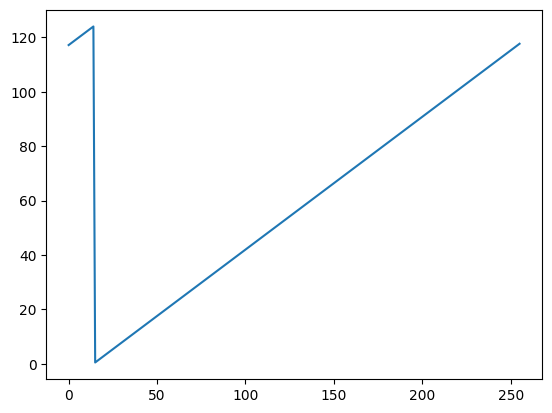

In [2]:
l_s, l_s_f=LoRa_modulation(SF=7,BW=125,s=120,delta=0.5,c=1)
plt.plot(l_s_f)
with open('log.txt','w') as f:
  f.write("LoRa Modulation Working Attempt"+'\n'+"SF=7, BW=125, s=120"+'\n')
  for i in l_s_f:
    f.write(str(i)+' ')
  f.write('\n')

In [3]:
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt

class LoraReservedArtifacts(Enum):
    FULL_UPCHIRP = 0
    FULL_DOWNCHIRP = 1
    QUARTER_DOWNCHIRP = 2


class LoraModulator:
    def __init__(self, spreading_factor, bandwidth, resolution_between_chips):
        # LoRa technique external parameters
        self.__spreading_factor = spreading_factor
        self.__bandwidth = bandwidth
        self.__resolution_between_chips = resolution_between_chips

        # Lora technique internal parameters
        self.__chips_number = 2 ** spreading_factor
        self.__symbol_duration = self.__chips_number / bandwidth
        self.__samples_per_symbol = int(self.__chips_number * resolution_between_chips)
        self.__sampling_period = self.__symbol_duration / self.__samples_per_symbol
        self.__frequency_slope = (bandwidth ** 2) / self.__chips_number

    def generate_frequency_evolution_across_time(self, symbols, return_only_offset_time_axis= True):

        frequency_evolution = []
        time_axis = []
        time_axis_without_offset = []
        current_offset = 0
        
        for symbol in symbols:
            current_slope = self.__frequency_slope

            
            
            symbol_time_axis = np.linspace(current_offset, current_offset + self.__symbol_duration, self.__samples_per_symbol)
            # print(current_offset+ self.__symbol_duration, symbol_time_axis[-1])  
            if symbol == LoraReservedArtifacts.FULL_UPCHIRP:
                symbol = 0

            elif symbol == LoraReservedArtifacts.FULL_DOWNCHIRP:
                symbol = 2**self.__spreading_factor - 1
                current_slope = - current_slope
            
            elif symbol == LoraReservedArtifacts.QUARTER_DOWNCHIRP:
                symbol = 2**self.__spreading_factor - 1
                current_slope = - current_slope
                quarter_cycle_max_index = int(len(symbol_time_axis) // 4 + 1)
                symbol_time_axis = symbol_time_axis[:quarter_cycle_max_index]
        
            # Not using chips number due to theorical reasons (equivalent in value, not in meaning)
            y_intercept = symbol * ( self.__bandwidth / (2**self.__spreading_factor) )
   

            for i in range(len(symbol_time_axis)):
                instantaneous_frequency = y_intercept + current_slope * (symbol_time_axis[i] - current_offset) % self.bandwidth

                if instantaneous_frequency > self.__bandwidth:
                    # Not necesarry to take into account multiples of bandwidth, as the duration of the chirp is limited 
                    # (i think)
                    instantaneous_frequency -= self.__bandwidth


                frequency_evolution.append(instantaneous_frequency)
            
            time_axis.extend(symbol_time_axis)
            symbol_time_axis_without_offset = symbol_time_axis - current_offset
            time_axis_without_offset.extend(symbol_time_axis_without_offset)
            
            time_stop = symbol_time_axis[-1] + self.__sampling_period
            current_offset = time_stop
            
        if return_only_offset_time_axis:
            return time_axis, frequency_evolution
        if not return_only_offset_time_axis:
            return time_axis, time_axis_without_offset,frequency_evolution
        return time_axis, frequency_evolution
    
    def generate_chirp_from_frequency_evolution(self, time_axis, frequency_evolution):
        coefficient = 1/np.sqrt(np.sqrt(2**self.__spreading_factor)*self.resolution_between_chips)
        signal = []
        for i in range(len(time_axis)):
            instantaneous_phase = 1j * 2 * np.pi * frequency_evolution[i] * time_axis[i]
            signal_sample = coefficient * np.exp(instantaneous_phase)
            signal.append(signal_sample)
        return signal
        
    def modulate_symbols(self, symbols, also_return_frequency_evolution = False):
        for symbol in symbols:
            if symbol not in range(self.__chips_number) and not isinstance(symbol, LoraReservedArtifacts):
                raise ValueError(f"Symbols have to be of type LoraReservedArtifacts or integers between 0 and {self.__chips_number - 1} for the spreading factor that was configurated.")
        time_axis, no_offset_time_axis, frequency_evolution = self.generate_frequency_evolution_across_time(symbols, False)
        signal = self.generate_chirp_from_frequency_evolution(no_offset_time_axis, frequency_evolution)
        if not also_return_frequency_evolution:
            return time_axis, signal
        return time_axis, signal, frequency_evolution

    
    def modulate_implicit_package(self,preamble_number, payload, also_return_frequency_evolution = False):
        package = []
        for i in range(preamble_number):
            package.append(LoraReservedArtifacts.FULL_UPCHIRP)
        for i in range(2):
            package.append(LoraReservedArtifacts.FULL_UPCHIRP)
        for i in range(2):
            package.append(LoraReservedArtifacts.FULL_DOWNCHIRP)
        package.append(LoraReservedArtifacts.QUARTER_DOWNCHIRP)

        package.extend(payload)
        time_axis, signal, frequency_evolution = self.modulate_symbols(package, True)
        if not also_return_frequency_evolution:
            return time_axis, signal
        return time_axis, signal, frequency_evolution
    
    @property
    def spreading_factor(self):
        return self.__spreading_factor
    @spreading_factor.setter
    def spreading_factor(self, value):
        if value not in [7, 8, 9, 10, 11, 12]:
            raise ValueError("Spreading factor has to be one of the integers: 7, 8, 9, 10, 11 or 12")
        self.__spreading_factor = value
        self.__chips_number = 2 ** value
        self.__symbol_duration = self.__chips_number / self.__bandwidth
        self.__samples_per_symbol = int(self.__chips_number * self.resolution_between_chips)
        self.__sampling_period = self.__symbol_duration / self.__samples_per_symbol
        self.__frequency_slope = (self.__bandwidth ** 2) / self.__chips_number

    @property
    def bandwidth(self):
        return self.__bandwidth
    @bandwidth.setter
    def bandwidth(self, value):
        if value not in [125, 250, 500]:
            raise ValueError("Bandwidth has to be one of the integers: 125, 250 or 500. Remember that it is in kHz.")
        self.__bandwidth = value
        self.__symbol_duration = self.__chips_number / value
        self.__samples_per_symbol = int(self.__chips_number * self.resolution_between_chips)
        self.__sampling_period = self.__symbol_duration / self.__samples_per_symbol
        self.__frequency_slope = (value ** 2) / self.__chips_number

    @property
    def resolution_between_chips(self):
        return self.__resolution_between_chips
    @resolution_between_chips.setter
    def resolution_between_chips(self, value):
        if value < 1:
            raise ValueError("Resolution between chips has to be greater than 0")
        if value % 2 != 0:
            print("Be careful, the resolution between chips is not a multiple of 2. This may lead to errors.")
        self.__resolution_between_chips = value
        self.__samples_per_symbol = int(self.__chips_number * value)
        self.__sampling_period = self.__symbol_duration / self.__samples_per_symbol


    



f>fMax 0.5
0.48828125


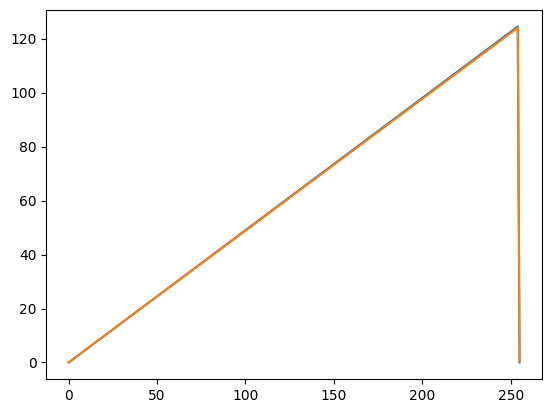

In [4]:
lora_mod_test_1 = LoraModulator(7, 125, 2)
time1, sig1, freq1 = lora_mod_test_1.modulate_symbols([0], True)

sig_og, freq_og=LoRa_modulation(SF=7,BW=125,s=0,delta=0.5,c=1)

plt.plot(freq1)
plt.plot(freq_og)

with open('log.txt','w') as f:

  f.write("LoRa Modulation Working Attempt"+'\n'+"SF=7, BW=125, s=120"+'\n')
  for i in freq_og:
    f.write(str(i)+' ')

  f.write('\n'+'Frequency length: ' + str(len(freq_og)))
  f.write('\n')

  f.write("LoRa Modulation Testing 1 Attempt"+'\n'+"SF=7, BW=125, s=120"+'\n')
  for i in freq1:
    f.write(str(round(i,8))+' ')

  f.write('\n'+'Frequency length: ' + str(len(freq1)))
  f.write('\n')

  f.write('Difference between the two frequency arrays: \n')
  for i in range(len(freq1)):
    f.write(str(freq1[i]-freq_og[i])+' ')

  #Getting the index of the first negative number of freq_og
  f.write('\n'+str(freq_og[15])+' vs '+ str(freq1[15])+'\n')

In [3]:
def get_freq(s,sf, bw):
    freqs=[]
    for k in range(2**sf):
        f=(s+k)*bw/(2**sf)
        if f>bw:
            f=f-bw
        freqs.append(f)
    return freqs


In [31]:
import numpy as np
def get_freq_2(s,sf, bw):
    T=1/bw

    time =np.arange(0, 2**sf*T, T)
    freqs=[]
    slope= bw / (2**sf*T)
    y_intercept = s*bw/(2**sf)
    
    for t in time:
        f = slope*t + y_intercept
        if f>bw:
            f=f-bw
        f = round(f, 8)
        freqs.append(f)
    
    return freqs

[0.0, 0.9765625, 1.953125, 2.9296875, 3.90625, 4.8828125, 5.859375, 6.8359375, 7.8125, 8.7890625, 9.765625, 10.7421875, 11.71875, 12.6953125, 13.671875, 14.6484375, 15.625, 16.6015625, 17.578125, 18.5546875, 19.53125, 20.5078125, 21.484375, 22.4609375, 23.4375, 24.4140625, 25.390625, 26.3671875, 27.34375, 28.3203125, 29.296875, 30.2734375, 31.25, 32.2265625, 33.203125, 34.1796875, 35.15625, 36.1328125, 37.109375, 38.0859375, 39.0625, 40.0390625, 41.015625, 41.9921875, 42.96875, 43.9453125, 44.921875, 45.8984375, 46.875, 47.8515625, 48.828125, 49.8046875, 50.78125, 51.7578125, 52.734375, 53.7109375, 54.6875, 55.6640625, 56.640625, 57.6171875, 58.59375, 59.5703125, 60.546875, 61.5234375, 62.5, 63.4765625, 64.453125, 65.4296875, 66.40625, 67.3828125, 68.359375, 69.3359375, 70.3125, 71.2890625, 72.265625, 73.2421875, 74.21875, 75.1953125, 76.171875, 77.1484375, 78.125, 79.1015625, 80.078125, 81.0546875, 82.03125, 83.0078125, 83.984375, 84.9609375, 85.9375, 86.9140625, 87.890625, 88.8671875

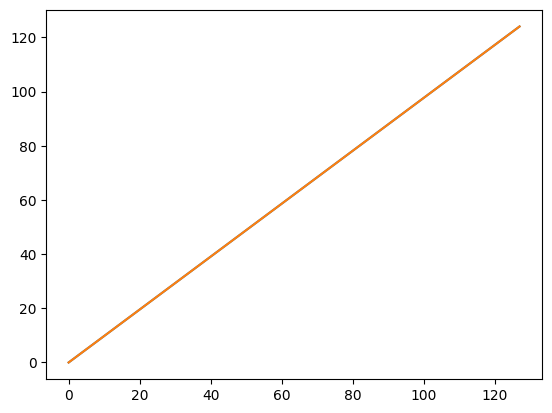

In [32]:
import matplotlib.pyplot as plt
freqs_1=get_freq(0,7,125)
freqs_2=get_freq_2(0,7,125)
plt.plot(freqs_1)
plt.plot(freqs_2)
print(freqs_1)
print(freqs_2)
print(len(freqs_1), len(freqs_2))
for i in range(len(freqs_1)):
    k = freqs_1[i]-freqs_2[i]
    if k!=0:
        print("No coincide en el indice: ", i)
        print(freqs_1[i], freqs_2[i])

with open('a.txt', 'w') as file:
    for i in freqs_1:
        file.write(str(i)+' ')
    file.write('\n')
    for i in freqs_2:
        file.write(str(i)+' ')
    file.write('\n')


In [56]:
T = 1/125
time1 = np.arange(0, 2**7 * T , T/2)

time2 = np.linspace(0, 2**7 * T , 2**7 * 2)

print(len(time1), len(time2))
for i in range(len(time1)):
    k = time1[i]-time2[i]
    if k!=0:
        print("No coincide en el indice: ", i)
        print(time1[i], time2[i])



256 256
No coincide en el indice:  1
0.004 0.004015686274509804
No coincide en el indice:  2
0.008 0.008031372549019608
No coincide en el indice:  3
0.012 0.01204705882352941
No coincide en el indice:  4
0.016 0.016062745098039215
No coincide en el indice:  5
0.02 0.02007843137254902
No coincide en el indice:  6
0.024 0.02409411764705882
No coincide en el indice:  7
0.028 0.028109803921568626
No coincide en el indice:  8
0.032 0.03212549019607843
No coincide en el indice:  9
0.036000000000000004 0.03614117647058823
No coincide en el indice:  10
0.04 0.04015686274509804
No coincide en el indice:  11
0.044 0.04417254901960784
No coincide en el indice:  12
0.048 0.04818823529411764
No coincide en el indice:  13
0.052000000000000005 0.05220392156862745
No coincide en el indice:  14
0.056 0.05621960784313725
No coincide en el indice:  15
0.06 0.06023529411764706
No coincide en el indice:  16
0.064 0.06425098039215686
No coincide en el indice:  17
0.068 0.06826666666666667
No coincide en el 

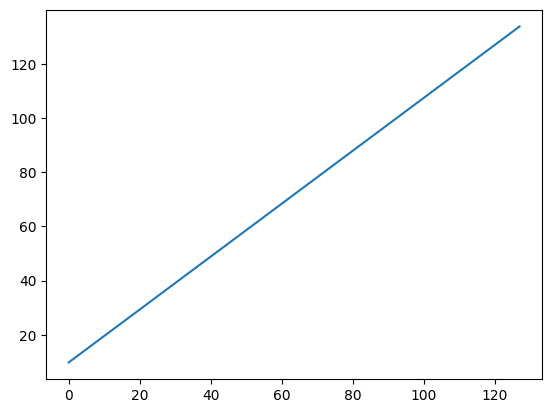

In [73]:
import numpy as np
s = 10
bw = 125
T = 1/bw
signal= []
freq_evolution = []
for k in range(2**7):
  coefficient = 1/np.sqrt(2**7)
  arg = s + k % (2**7)
  freq_evolution.append(arg*bw/(2**7)) 
  phase = 2*np.pi*arg*(bw/(2**7))*k*T
  signal.append( coefficient *np.exp(1j * phase))

plt.plot(freq_evolution)
with open('log.txt','w') as f:
  f.write("LoRa Modulation Working Attempt"+'\n'+"SF=7, BW=125, s=0"+'\n')
  for i in freq_evolution:
    f.write(str(i)+' ')
  f.write('\n')

In [84]:
import numpy as np

sf = 7
bw = 125000


timeline1 = [i*(1/bw) for i in range(2**sf)]
print(str(len(timeline1)) +'\n', timeline1)

timeline2 = np.linspace(0, (2**sf-1)*(1/bw), 2**sf )
print(timeline2)


128
 [0.0, 8e-06, 1.6e-05, 2.4e-05, 3.2e-05, 3.9999999999999996e-05, 4.8e-05, 5.6e-05, 6.4e-05, 7.2e-05, 7.999999999999999e-05, 8.8e-05, 9.6e-05, 0.000104, 0.000112, 0.00011999999999999999, 0.000128, 0.000136, 0.000144, 0.00015199999999999998, 0.00015999999999999999, 0.000168, 0.000176, 0.000184, 0.000192, 0.00019999999999999998, 0.000208, 0.000216, 0.000224, 0.000232, 0.00023999999999999998, 0.000248, 0.000256, 0.00026399999999999997, 0.000272, 0.00028, 0.000288, 0.000296, 0.00030399999999999996, 0.000312, 0.00031999999999999997, 0.000328, 0.000336, 0.00034399999999999996, 0.000352, 0.00035999999999999997, 0.000368, 0.000376, 0.000384, 0.000392, 0.00039999999999999996, 0.000408, 0.000416, 0.000424, 0.000432, 0.00043999999999999996, 0.000448, 0.00045599999999999997, 0.000464, 0.000472, 0.00047999999999999996, 0.000488, 0.000496, 0.000504, 0.000512, 0.00052, 0.0005279999999999999, 0.000536, 0.000544, 0.000552, 0.00056, 0.0005679999999999999, 0.000576, 0.000584, 0.000592, 0.0006, 0.00060